# Reconocimiento Facial de Emociones
Se utilizan tres clasificadores de scikit learn para reconocer tres emociones básicas Alegría, Rabia y Tristeza.

In [50]:
import pandas as pd
import numpy as np
import imutils
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [2]:
# Versiones de los paquetes usados en este notebook

%reload_ext watermark
%watermark -a "César S. Hooper/ Dic 2021" --iversions
!python --version

Author: César S. Hooper/ Dic 2021

pandas    : 1.2.4
imutils   : 0.5.4
cv2       : 4.5.4-dev
skimage   : 0.18.1
sklearn   : 0.24.1
seaborn   : 0.11.1
numpy     : 1.19.5
matplotlib: 3.3.4

Python 3.8.8


### Resumen

Para este notebook se realizaron grabaciones de video con las expresiones faciales que representan, de manera acentuada, las emociones mencionadas.
Luego, se procedió a separar los frames de cada video y guardar las imágenes en directorios diferentes. 
Se creó un dataframe con labels indicando cada emoción, 

* Alegría : 0
* Rabia : 1
* Tristeza: 2

Una vez creado el dataframe se procedió a entrenar los clasificadores.
Se evaluó el desempeño de cada clasificador realizando un reconocimiento facial de emoción en tiempo real, después de cada entrenamiento. 

### Preparación de los datos

In [6]:
## Las tres emociones con las que se desarrolla el notebook
emociones = ['alegria', 'rabia', 'tristeza']
salida_path = 'C:/Users/Cesar Hooper/Desktop/github/reconocimiento_facial/emociones'

In [4]:
# carga videos de emociones y guarda los frames en carpetas con nombre de emocion



for emocion in emociones:
    llegada = salida_path + '/' + emocion
    if not os.path.exists(llegada):
        os.mkdir(llegada)
        
    video = salida_path + '/' + emocion + '.mp4'
    #print(video)
    cap = cv2.VideoCapture(str(video))
    
    faceclassif = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    caras = []      
    count = 0
    
    while True:
        ret, frame = cap.read()
        #print(ret)
        if ret == False: break
            
        # redimensionamos los frames usando imutils y los pasamos al gris
        frame = imutils.resize(frame, width=300)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        auxframe = frame.copy()
        
        # usamos detecMultiScale() para detectar las coordenadas de los rostros
        faces = faceclassif.detectMultiScale(gray, 1.3,5)
        
        for faz in faces:
            x,y,w,h = faz
            #print(faz)
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0),2)
            rostro = auxframe[y:y+h, x:x+w]
            rostro =cv2.resize(rostro, (100, 100), interpolation=cv2.INTER_CUBIC)
            
            
            cv2.imwrite(llegada + '/rostro' + str(count) + '.jpg', rostro)
            
        cv2.imshow('frame', frame)
        count += 1
        
        k = cv2.waitKey(1)
        if k == 27 or count >= 1000: break
    cap.release()
    cv2.destroyAllWindows()



A continuación una muestra de algunos frames con las tres emociones.
Se acentuaron bastante las expresiones en el rostro de cada emoción para facilitar el entrenamiento de cada modelo, pues utilizaremos -apenas- alrededor de 700 imágenes de cada emoción para los entrenamientos.

Podría inferirse que, con más imágenes, y más tiempo de entrenamiento, los modelos podrían eventualmente aprender más detalles de cada emoción y ser más precisos al momento de clasificar una expresión facial. Sin embargo, ésto no necesariamente es cierto pues, incluso para la percepción humana, muchas veces es difícil identificar la emoción que expresa un rostro. 

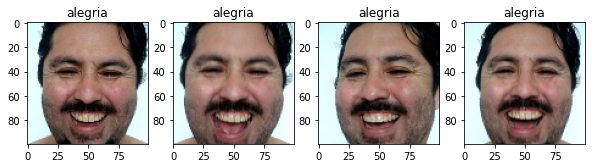

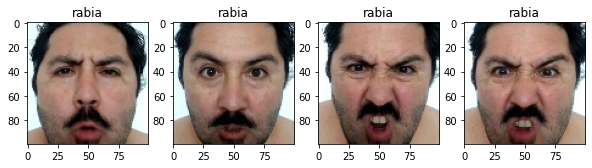

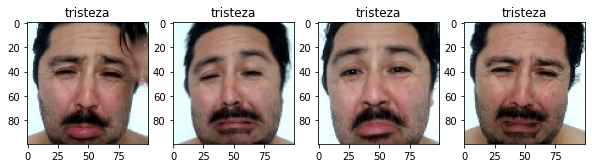

In [7]:
k = 1
for emocion in emociones:
    
    ruta = salida_path + '/' + emocion
    plt.figure(figsize=(10,10))
    for imagen in np.random.choice(os.listdir(ruta), 4):
        
        img = plt.imread(ruta + '/' + imagen)
        plt.subplot(3, 4, k)
        plt.imshow(img)
        plt.title(emocion)
        
        k += 1
    

In [8]:
# carga imágenes para luego contruir un dataframe con labels
# 0: alegria, 1: rabia, 2: tristeza

path = 'C:/Users/Cesar Hooper/Desktop/github/reconocimiento_facial/emociones/'
lista = []
for emocion in emociones:
    
    n = 0
    emocion_dir = path + emocion
       
    for foto in os.listdir(emocion_dir):
        
        imagen_dir = emocion_dir + '/' + foto
        img = cv2.imread(imagen_dir)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #print(img.shape, imagen_dir)
        lista.append(img)
        
        if n == 717: break
        
        n += 1

# tranformar la lista en array
x = np.array(lista)

# las matrices dentro del array en arrays de (1, 10000)
x = x.reshape(-1,10000) # este es un array de (4004, 10000)

x.shape

(2154, 10000)

In [9]:
# creamos diccionario y  luego dataframe
s = {}
for columna in range(x.shape[1]):
    s['p'+str(columna)] = list(x[:,columna])

dataframe = pd.DataFrame(s)    

# crear labels
k = np.arange(3)
labels = np.repeat(k, dataframe.shape[0]/3)

dataframe['target'] = labels

# randomizamos las filas del dataframe
dataframe_random = dataframe.sample(frac=1).reset_index(drop=True)

# separamos los datos de imágenes de los labels
y = dataframe_random['target']
X = dataframe_random.drop(['target'], axis=1)

In [10]:
dataframe_random.head(10)

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p9991,p9992,p9993,p9994,p9995,p9996,p9997,p9998,p9999,target
0,254,255,255,254,255,254,253,253,253,237,...,165,165,166,167,168,169,171,172,173,1
1,248,248,248,248,248,248,248,248,247,247,...,157,160,162,165,168,168,171,169,169,2
2,244,246,243,246,245,244,245,243,242,243,...,138,143,148,151,154,160,162,164,165,0
3,243,243,243,242,243,243,244,244,242,246,...,152,157,160,162,209,241,249,251,250,2
4,247,247,247,247,247,247,247,247,246,247,...,166,168,169,170,170,170,168,162,166,2
5,242,242,242,243,244,245,244,244,246,242,...,238,246,251,249,247,249,249,249,249,2
6,248,248,248,248,248,248,248,248,245,242,...,148,150,155,157,158,160,161,164,165,2
7,252,252,253,252,251,251,245,176,128,32,...,158,158,158,160,161,160,162,166,168,1
8,246,246,246,246,246,246,247,247,247,246,...,159,161,163,167,166,165,173,169,168,0
9,233,234,235,233,237,234,234,236,234,237,...,170,206,243,249,249,249,249,250,250,0


In [11]:
_, cant = np.unique(dataframe_random['target'], return_counts=True)
print('Hay ' + str(cant) + ' de cada label')

Hay [718 718 718] de cada label


#### Separación de datos para entrenamiento y test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 30% test

### Entrenamiento de Random-Forest

In [13]:

# crea Classifier
clf=RandomForestClassifier(n_estimators=200)

# Entrena modelo y lo aplica para predecir
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:%.5f"%metrics.accuracy_score(y_test, y_pred))

Accuracy:1.00000


#### Modelo RF y reconocimiento de emoción en tiempo real

In [52]:
cap = cv2.VideoCapture(0)
faceclassif = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
i = 0
while True:
    ret, frame = cap.read()
    
    if ret == False:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    auxframe = gray.copy()
    
    #rostro = cv2.resize(gray, (100, 100))
    

    faces = faceclassif.detectMultiScale(gray, 1.3, 5)

    for faz in faces:
        x,y,h,w = faz
        rostro = auxframe[y:y+h, x:x+w]
        rostro = cv2.resize(rostro, (100,100), interpolation=cv2.INTER_CUBIC)
        
        z = rostro.reshape(-1, 10000)
        dataframe = pd.DataFrame(z)
            
       
        #result = face_recognizer.predict(rostro)
        resultado = clf.predict(dataframe)
        prob = clf.predict_proba(dataframe)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0),2)
        
        # 0: alegria, 1: rabia, 2: tristeza
        nuevo_dir = salida_path + '/random_forest'
        if not os.path.exists(nuevo_dir): os.mkdir(nuevo_dir)
        
        
        if resultado[0] == 0:
            cv2.putText(frame, '{}'.format('ALEGRIA ' + str(prob[0][0])), (x,y-5), 1,1.3,(255,255,0),1,cv2.LINE_AA)
            cv2.imwrite(nuevo_dir + '/RF_cesar_alegria_' + str(i) + '.jpg', frame)
        elif resultado[0] == 1:
            cv2.putText(frame, '{}'.format('RABIA '+ str(prob[0][1])), (x,y-5), 1,1.3,(255,255,0),1,cv2.LINE_AA)
            cv2.imwrite(nuevo_dir + '/RF_cesar_rabia_' + str(i) + '.jpg', frame)
        elif resultado[0] == 2:
            cv2.putText(frame, '{}'.format('TRISTEZA ' + str(prob[0][2])), (x,y-5), 1,1.3,(255,255,0),1,cv2.LINE_AA)
            cv2.imwrite(nuevo_dir + '/RF_cesar_tristeza' + str(i) + '.jpg', frame)
            
    cv2.imshow('frame', frame)
    
    i += 1
    k = cv2.waitKey(1)
    if k == 27: break

cap.release()
cv2.destroyAllWindows()

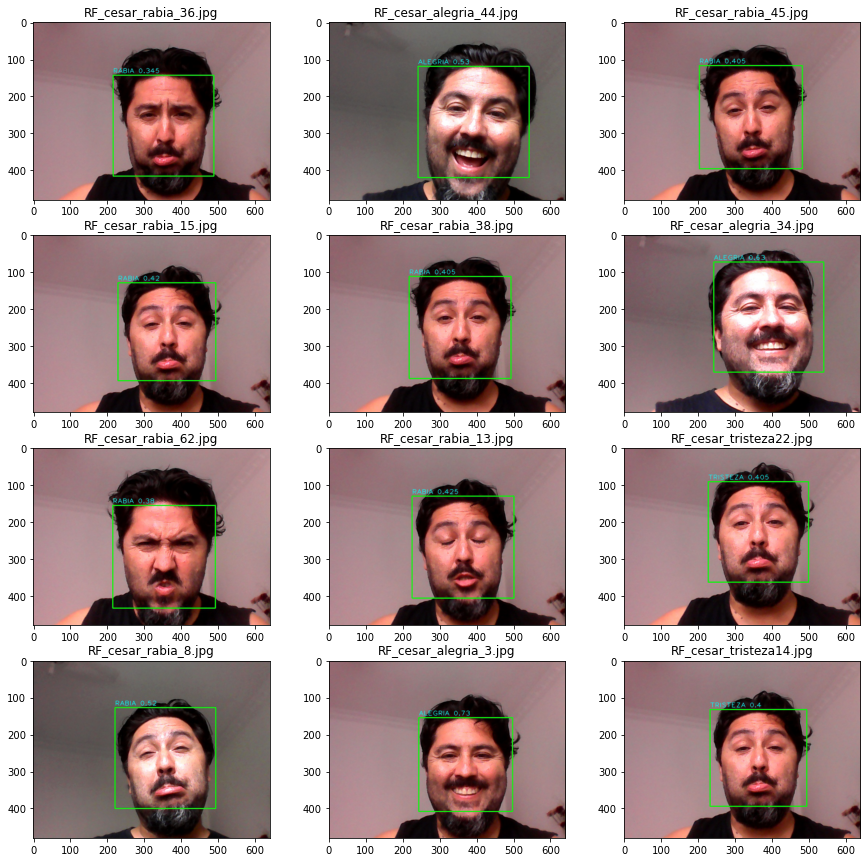

In [54]:
ruta_rf = salida_path + '/random_forest'
k = 1
plt.figure(figsize=(15,15))
for imagen in np.random.choice(os.listdir(ruta_rf), 12):
    
    img = plt.imread(ruta_rf + '/' + imagen)
    plt.subplot(4,3, k)
    plt.imshow(img)
    plt.title(imagen)
    
    k += 1

Se observa que el clasificador Random-Forest (con esta configuración de hiperparámetros) "reconoce" la tristeza como rabia. 

### Entrenamiento de Gradient Boosting Classifier

In [39]:
# creación del modelo, entrenamiento y predicción
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbc.fit(X_train, y_train)

y_pred_gbc = gbc.predict(X_test)
print("Accuracy:%.5f"%metrics.accuracy_score(y_test, y_pred_reg))


Accuracy:1.00000


#### Modelo GB y reconocimiento de emoción en tiempo real

In [55]:
cap = cv2.VideoCapture(0)
faceclassif = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
i = 0
while True:
    ret, frame = cap.read()
    
    if ret == False:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    auxframe = gray.copy()
    
    faces = faceclassif.detectMultiScale(gray, 1.3, 5)

    for faz in faces:
        x,y,h,w = faz
        rostro = auxframe[y:y+h, x:x+w]
        rostro = cv2.resize(rostro, (100,100), interpolation=cv2.INTER_CUBIC)
        
        z = rostro.reshape(-1, 10000)
        dataframe2 = pd.DataFrame(z)
            
       
        #result = face_recognizer.predict(rostro)
        resultado_gbc = gbc.predict(dataframe2)
        prob_gbc = gbc.predict_proba(dataframe2)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0),2)
        
        # 0: alegria, 1: rabia, 2: tristeza
        
        nuevo_dir = salida_path + '/gradient_booster'
        if not os.path.exists(nuevo_dir): os.mkdir(nuevo_dir)
               
        if resultado_gbc[0] == 0:
            cv2.putText(frame, '{}'.format('ALEGRIA'), (x,y-5), 1,1.3,(255,255,0),1,cv2.LINE_AA)
            cv2.imwrite(nuevo_dir + '/GB_cesar_alegria_' + str(i) + '.jpg', frame)
        elif resultado_gbc[0] == 1:
            cv2.putText(frame, '{}'.format('RABIA'), (x,y-5), 1,1.3,(255,255,0),1,cv2.LINE_AA)
            cv2.imwrite(nuevo_dir + '/GB_cesar_rabia_' + str(i) + '.jpg', frame)
        elif resultado_gbc[0] == 2:
            cv2.putText(frame, '{}'.format('TRISTEZA'), (x,y-5), 1,1.3,(255,255,0),1,cv2.LINE_AA)
            cv2.imwrite(nuevo_dir + '/GB_cesar_tristeza' + str(i) + '.jpg', frame)
            
    cv2.imshow('frame', frame)
        
    i += 1   

    k = cv2.waitKey(1)
    if k == 27: break

cap.release()
cv2.destroyAllWindows()

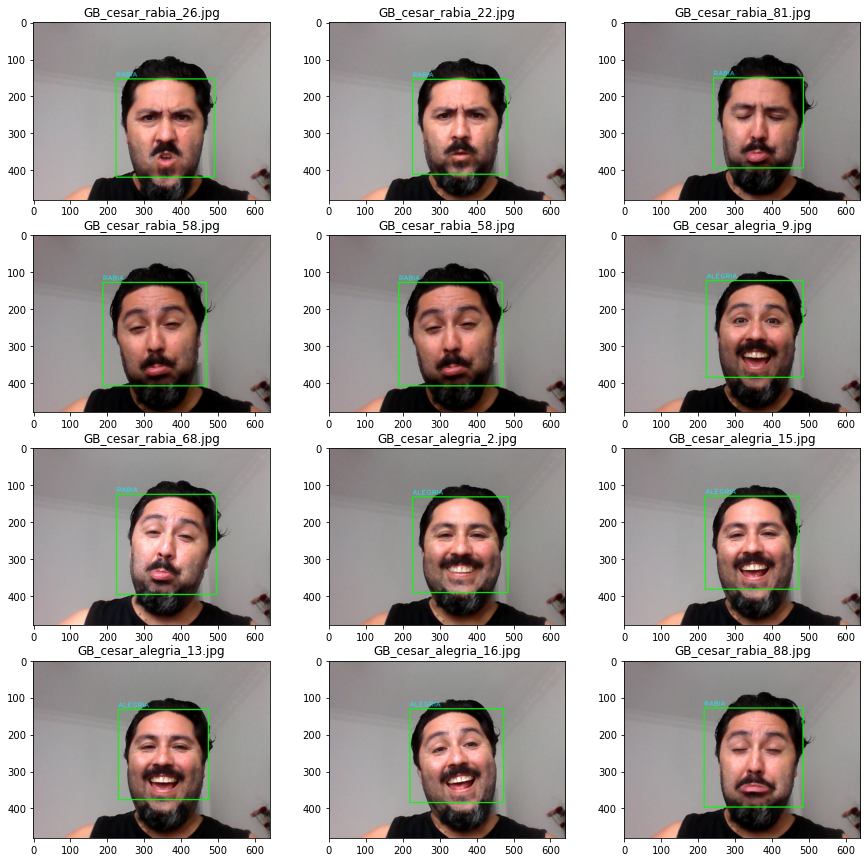

In [56]:
ruta_gb = salida_path + '/gradient_booster'
k = 1
plt.figure(figsize=(15,15))
for imagen in np.random.choice(os.listdir(ruta_gb), 12):
    
    img = plt.imread(ruta_gb + '/' + imagen)
    plt.subplot(4,3, k)
    plt.imshow(img)
    plt.title(imagen)
    
    k += 1

Este clasificador también reconoce la expresión facial de tristeza como rabia.

### Neural Network classifier sklearn

In [59]:
# crea y entrena modelo

nnc = MLPClassifier(random_state=1, max_iter=300)
nnc.fit(X_train, y_train)

y_pred_nnc = nnc.predict(X_test)
print("Accuracy:%.5f"%metrics.accuracy_score(y_test, y_pred_nnc))

Accuracy:0.99304


In [61]:
cap = cv2.VideoCapture(0)
faceclassif = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
i = 0
while True:
    ret, frame = cap.read()
    
    if ret == False:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    auxframe = gray.copy()    

    faces = faceclassif.detectMultiScale(gray, 1.3, 5)

    for faz in faces:
        x,y,h,w = faz
        rostro = auxframe[y:y+h, x:x+w]
        rostro = cv2.resize(rostro, (100,100), interpolation=cv2.INTER_CUBIC)
        
        z = rostro.reshape(-1, 10000)
        dataframe3 = pd.DataFrame(z)
            
       
        #result = face_recognizer.predict(rostro)
        resultado_nnc = nnc.predict(dataframe3)
        prob_nnc = nnc.predict_proba(dataframe3)
        #print(resultado)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0),2)
        
        # 0: alegria, 1: rabia, 2: tristeza
        
        nuevo_dir = salida_path + '/neural_network'
        if not os.path.exists(nuevo_dir): os.mkdir(nuevo_dir)
        
        
        if resultado_nnc[0] == 0:
            cv2.putText(frame, '{}'.format('ALEGRIA'), (x,y-5), 1,1.3,(255,255,0),1,cv2.LINE_AA)
            cv2.imwrite(nuevo_dir + '/NN_cesar_alegria_' + str(i) + '.jpg', frame)
        elif resultado_nnc[0] == 1:
            cv2.putText(frame, '{}'.format('RABIA'), (x,y-5), 1,1.3,(255,255,0),1,cv2.LINE_AA)
            cv2.imwrite(nuevo_dir + '/NN_cesar_rabia_' + str(i) + '.jpg', frame)
        elif resultado_nnc[0] == 2:
            cv2.putText(frame, '{}'.format('TRISTEZA'), (x,y-5), 1,1.3,(255,255,0),1,cv2.LINE_AA)
            cv2.imwrite(nuevo_dir + '/NN_cesar_tristeza_' + str(i) + '.jpg', frame)
            
                
            
    cv2.imshow('frame', frame)
    
    i += 1
    k = cv2.waitKey(1)
    if k == 27: break

cap.release()
cv2.destroyAllWindows()

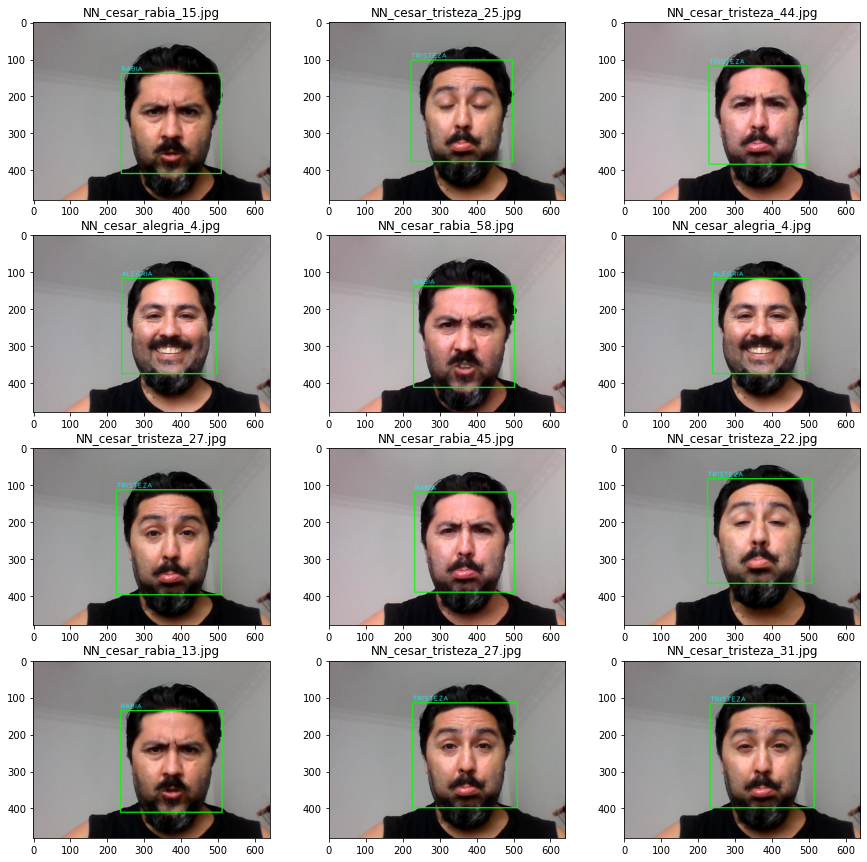

In [64]:
ruta_nn = salida_path + '/neural_network'
k = 1
plt.figure(figsize=(15,15))
for imagen in np.random.choice(os.listdir(ruta_nn), 12):
    
    img = plt.imread(ruta_nn + '/' + imagen)
    plt.subplot(4,3, k)
    plt.imshow(img)
    plt.title(imagen)
    
    k += 1

Este clasificador reconoce correctamente todas las expresiones faciales. 

## FIN